In [1]:
## Step 0 - Importing libraries and paths

import DrainMethod
import sys
import os

## General parameters 

input_dir = os.path.join(os.getcwd(), "logs") # The input directory of raw logs
output_dir = os.path.join(os.getcwd(), "parsings")  # The output directory of parsing results
vector_dir = os.path.join(os.getcwd(), "embeddings")  # The vector directory of converted logs

#logName = 'ciena-mini.txt' 
logName = 'log-lines.txt' # Name of file to be parsed

log_format = '<Content>' # Format of the file, if there are different fields
regex = [] # Regex strings for Drain execution

In [2]:
## Step 1 - Parsing using Drain

from pathlib import Path
import pickle

## Drain parameters
st = 0.5 # Drain similarity threshold
depth = 5 # Max depth of the parsing tree

## Parses file, using DrainMethod
print('\n=== Starting Drain Parsing ===')
indir = os.path.join(input_dir, os.path.dirname(logName))
print(indir)
log_file = os.path.basename(logName)

parser = DrainMethod.LogParser(log_format=log_format, indir=indir, outdir=output_dir, rex=regex, depth=depth, st=st)
drain_results = parser.parse(log_file)


=== Starting Drain Parsing ===
/home/vbertalan/Downloads/Projeto CSL/CSL/CSL/logs/
Parsing file: /home/vbertalan/Downloads/Projeto CSL/CSL/CSL/logs/log-lines.txt


Parsing Progress: 100%|██████████| 15710/15710 [00:00<00:00, 24567.15it/s]


In [3]:
## Step 2 - Slicing dataset

import pandas as pd

bin = 60
dataset_size = len(drain_results)
bin_number = int(dataset_size/bin)

# Gets the unique template values
## Talvez trocar para EventId?
template_values = drain_results['EventTemplate'].unique()

In [38]:
%%time

## Step 3 - Creating matrix

import pandas as pd

# Creating the DataFrame with zeros
result_df = pd.DataFrame(0, index=range(len(template_values)), columns=range(1, bin_number + 1))

# Inserting the 'Template' column
result_df.insert(loc=0, column='Template', value=template_values)

# Initializing column index
col = 0

# Iterating over drain_results
for i, event_template in enumerate(drain_results['EventTemplate']):
    # Finding the right column
    if i % bin == 0 and col < bin_number:
        col += 1

    # Finding the right row
    row = result_df.index[result_df['Template'] == event_template][0]
    
    # Updating the cell
    result_df.at[row, col] += 1

CPU times: total: 3 s
Wall time: 3 s


In [25]:
## Step 4 (optional) - Prints dataframe to external CSV 

# Print to CSV
print(result_df)
result_df.to_csv('out-bins.csv', index=False, sep='¡')

                                              Template   1   2   3   4   5  \
0            jq: error (at <*> null (null) has no keys   4   0   0   0   0   
1                   <*> line <*> <*> command not found   1   0   0   0   0   
2        cp: cannot stat <*> No such file or directory  50  60  60  60  60   
3              /bin/bash: cleartool: command not found   1   0   0   0   0   
4        sed: can't read <*> No such file or directory   1   0   0   0   0   
..                                                 ...  ..  ..  ..  ..  ..   
137  NOTE: recipe ofm1t2-32-gitrAUTOINC+9589a088de_...   0   0   0   0   0   
138  [ERROR] Failed to execute goal org.apache.mave...   0   0   0   0   0   
139                        : no newline at end of file   0   0   0   0   0   
140  rm: cannot remove ‘cache/pots-pts/u-boot-a9’: ...   0   0   0   0   0   
141  CC apps/osrpcp/protocols/PNNI/routing/comm/usr...   0   0   0   0   0   

      6   7   8   9  ...  252  253  254  255  256  257  258  25

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.4/159.4 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 9.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.7/310.7 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 10.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.3 MB/s eta 0:00:00:00:0100:01


Working for n conditional variables: 5: 100%|██████████| 5/5 [02:54<00:00, 34.91s/it]


21


Working for n conditional variables: 5: 100%|██████████| 5/5 [00:21<00:00,  4.35s/it]


33


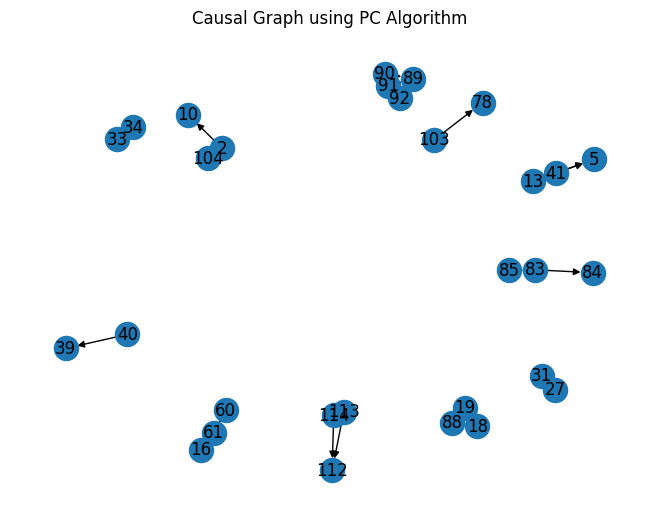

In [157]:
%%time

## Step 5 - Using PGMPY to calculate causality

# Use the PC algorithm to infer the causal structure

!pip install matplotlib

from pgmpy.estimators import PC
from pgmpy.independencies import Independencies

df_causality = result_df.drop(['Template'], axis=1)
df_causality.insert(0, 'Template', range(0,len(template_values)))
df_causality = df_causality.T

est = PC(df_causality)
model_chi = est.estimate(ci_test='chi_square')
print(len(model_chi.edges()))
model_gsq, _ = est.estimate(ci_test='g_sq', return_type='skeleton')
print(len(model_gsq.edges()))

# Visualize the resulting causal graph
import networkx as nx
import matplotlib.pyplot as plt

nx_graph = nx.DiGraph(model_chi.edges())
nx.draw(nx_graph, with_labels=True)
plt.title("Causal Graph using PC Algorithm")
plt.show()

In [23]:
%%time

## Step 6 - Testing temperature

# Creating blank matrix
import pandas as pd
template_values = drain_results['EventTemplate'].unique()

# Create a DataFrame with one column
result_df = pd.DataFrame(template_values, columns=['Template'])

col = 0
temperature = 5
result_df = pd.concat([result_df, pd.DataFrame({col: [0] * len(template_values)})], axis=1)
similar_lines = []

# Iterating over drain_results
for i, event_template in enumerate(drain_results['EventTemplate']):

    if event_template not in similar_lines:
        similar_lines.append(event_template)

    # Finding the right row
    row = result_df.index[result_df['Template'] == event_template][0]
    
    # Updating the cell
    result_df.at[row, col] += 1

    if len(similar_lines) == temperature:
        col += 1        
        result_df = pd.concat([result_df, pd.DataFrame({col: [0] * len(template_values)})], axis=1)                
        similar_lines = []

print(result_df)

                                              Template   0    1   2   3   4  \
0            jq: error (at <*> null (null) has no keys   2    3   1   3   0   
1                   <*> line <*> <*> command not found   1    0   0   0   0   
2        cp: cannot stat <*> No such file or directory  10  440  20  80  10   
3              /bin/bash: cleartool: command not found   1    0   0   0   0   
4        sed: can't read <*> No such file or directory   1    0   0   0   0   
..                                                 ...  ..  ...  ..  ..  ..   
137  NOTE: recipe ofm1t2-32-gitrAUTOINC+9589a088de_...   0    0   0   0   0   
138  [ERROR] Failed to execute goal org.apache.mave...   0    0   0   0   0   
139                        : no newline at end of file   0    0   0   0   0   
140  rm: cannot remove ‘cache/pots-pts/u-boot-a9’: ...   0    0   0   0   0   
141  CC apps/osrpcp/protocols/PNNI/routing/comm/usr...   0    0   0   0   0   

      5   6   7  8  ...  226  227  228  229  230  2

  0%|          | 0/5 [00:00<?, ?it/s]

Working for n conditional variables: 5: 100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


The number of subgraphs is 13


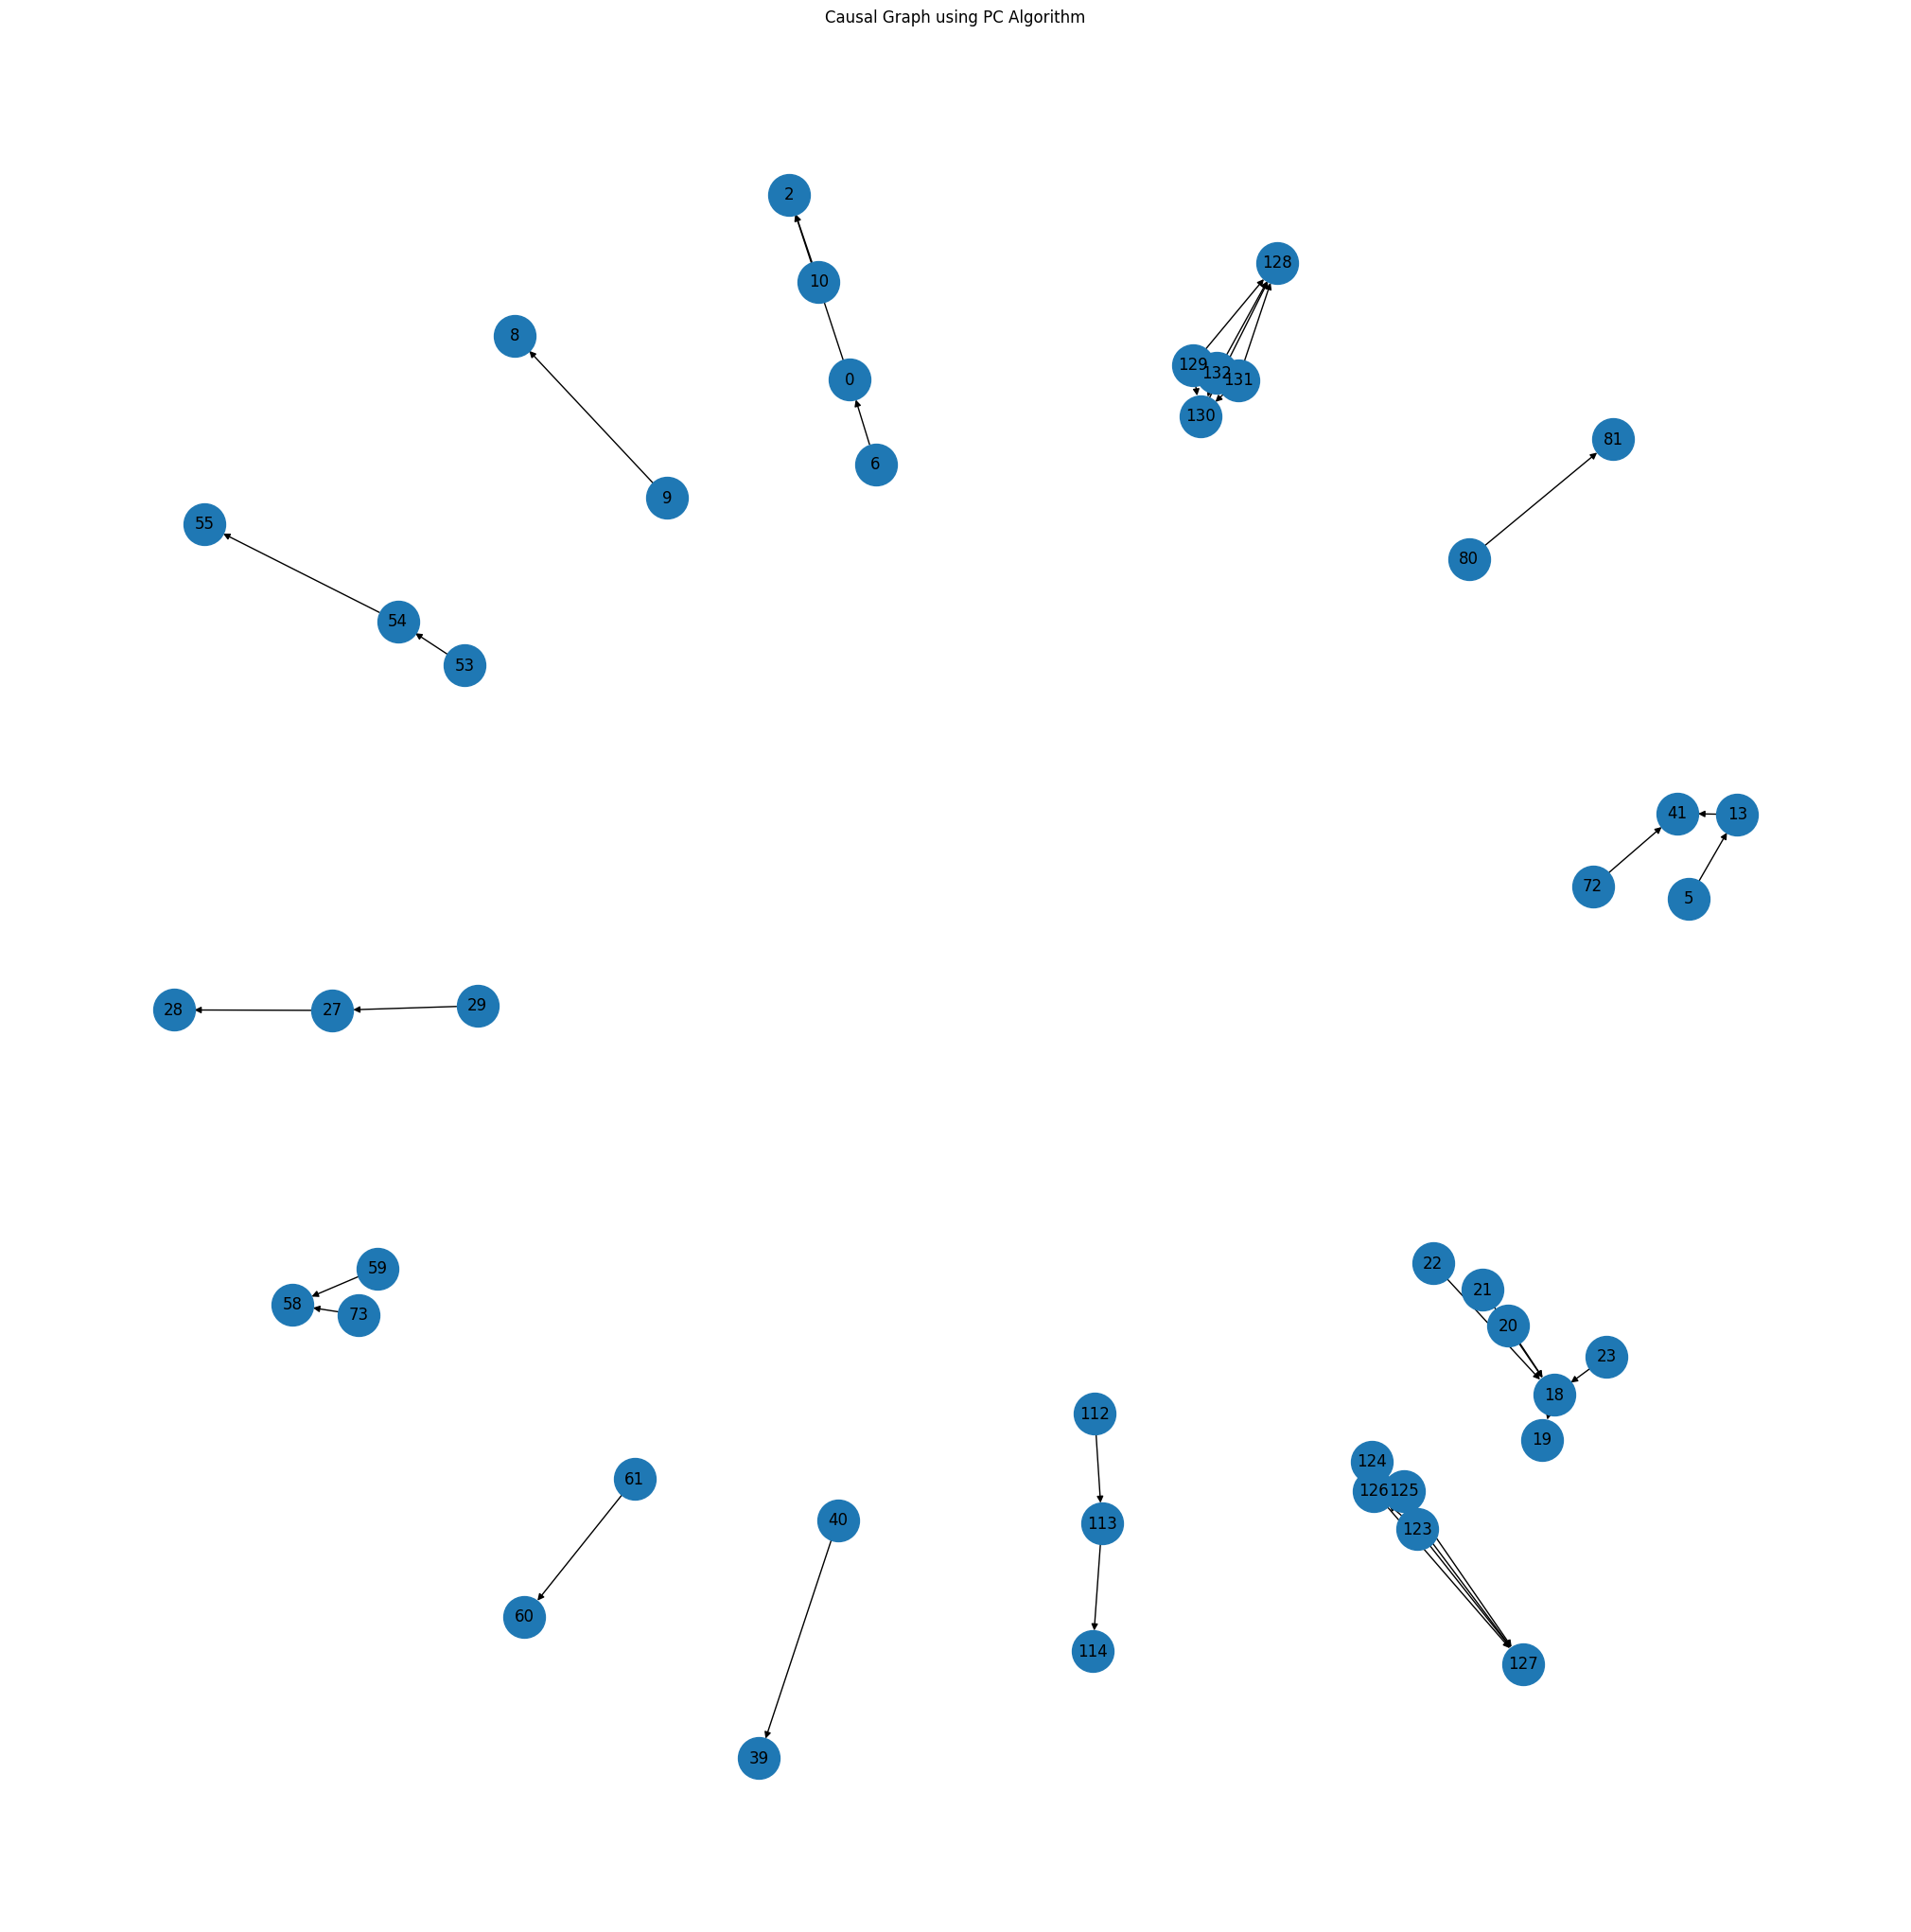

CPU times: user 2min 25s, sys: 148 ms, total: 2min 26s
Wall time: 2min 25s


In [24]:
%%time

## Step 7 - Using PGMPY to calculate causality in the new temperature method

# Use the PC algorithm to infer the causal structure

#!pip install matplotlib

from pgmpy.estimators import PC
from pgmpy.independencies import Independencies

df_causality = result_df.drop(['Template'], axis=1)
df_causality.insert(0, 'Template', range(0,len(template_values)))
df_causality = df_causality.T

est = PC(df_causality)
model_chi = est.estimate(ci_test='chi_square')
#print(len(model_chi.edges()))
model_gsq, _ = est.estimate(ci_test='g_sq', return_type='skeleton')
#print(len(model_gsq.edges()))

# Visualize the resulting causal graph
import networkx as nx
import matplotlib.pyplot as plt

nx_graph = nx.DiGraph(model_chi.edges())
print("The number of subgraphs is {}".format(nx.number_weakly_connected_components(nx_graph)))
plt.figure(figsize=(20,20))
nx.draw(nx_graph, node_size=1000, with_labels=True)
plt.title("Causal Graph using PC Algorithm")
plt.show()